In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path
import yaml

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
ndbs
Fri Nov  5 17:08:09 PDT 2021


# Changes from 4.5.2 to 4.5.3:

- mild->TMREL recovery rate updated from 1/1000 to 1/27.
- x-factor effects: i3=1, i2=3.16, i1=3.16.
- X-factor exposure dependent on wasting state at initialization: sam=0.6, mam=0.5, mild=0.25, tmrel=0.01

Also, Rajan identified the following bug (posted in Slack on Thu 11/4):

> i'm looking at the code now, and i think i am not calculating the x-factor paf correctly. it's being calculated based on an x-factor exposure of 22.155%, which i think must be an old value. the exposure should be dynamically calculated using wasting exposure and thie configurations for their effect on x-factor

So the results here will likely change after the bug is fixed.

# Load and clean data

Don't add `x_factor_effect` to index columns this time since it doesn't exist in this run.

In [2]:
data = csr.VivariumResults.cleaned_from_model_spec('4.5.3')
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [3]:
#vp.set_global_index_columns(vp.INDEX_COLUMNS+['x_factor_effect'])
vp.INDEX_COLUMNS

['input_draw', 'scenario']

# Create a dictionary to store figures to save later

In [4]:
figs = {}

In [5]:
!ls /ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/

v2.1_gbd_2020_wasting	       v2.4_corrected_fertility  v4.5.2_x_factor
v2.3_wasting_birth_prevalence  v2.5_stunting


# Compute x-factor prevalence by age group and year

In [6]:
data.person_time

,age,input_draw,measure,scenario,sex,sq_lns,wasting_treatment,x_factor,year,value
0,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2022,0.000000
1,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2023,0.000000
2,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2024,0.000000
3,1-5_months,29,person_time,baseline,female,covered,covered,cat1,2025,0.000000
...,...,...,...,...,...,...,...,...,...,...
17276,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2023,53.930185
17277,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2024,55.223819
17278,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2025,53.078713
17279,late_neonatal,946,person_time,wasting_treatment,male,uncovered,uncovered,cat2,2026,54.160164


In [7]:
x_factor_prevalence = csr.get_prevalence(data, 'x_factor', ['age', 'year'], multiplier=100)
x_factor_prevalence

,age,year,input_draw,scenario,x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,1-5_months,2022,29,baseline,cat1,12.243029,state_person_time,state_person_time,100,prevalence
1,1-5_months,2022,29,baseline,cat2,87.756971,state_person_time,state_person_time,100,prevalence
2,1-5_months,2022,29,sqlns,cat1,12.243029,state_person_time,state_person_time,100,prevalence
3,1-5_months,2022,29,sqlns,cat2,87.756971,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
2156,late_neonatal,2026,946,sqlns,cat1,12.538012,state_person_time,state_person_time,100,prevalence
2157,late_neonatal,2026,946,sqlns,cat2,87.461988,state_person_time,state_person_time,100,prevalence
2158,late_neonatal,2026,946,wasting_treatment,cat1,12.538012,state_person_time,state_person_time,100,prevalence
2159,late_neonatal,2026,946,wasting_treatment,cat2,87.461988,state_person_time,state_person_time,100,prevalence


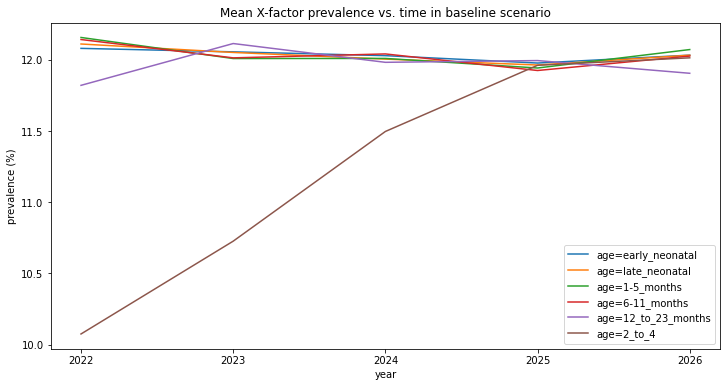

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
# x_factor_effect=1.1
csp.plot_over_time_by_column(
    x_factor_prevalence.query(f"scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'prevalence (%)',
    f"Mean X-factor prevalence vs. time in baseline scenario",
    False
)
figs['x_factor_prevalence_by_age_group_in_baseline'] = fig

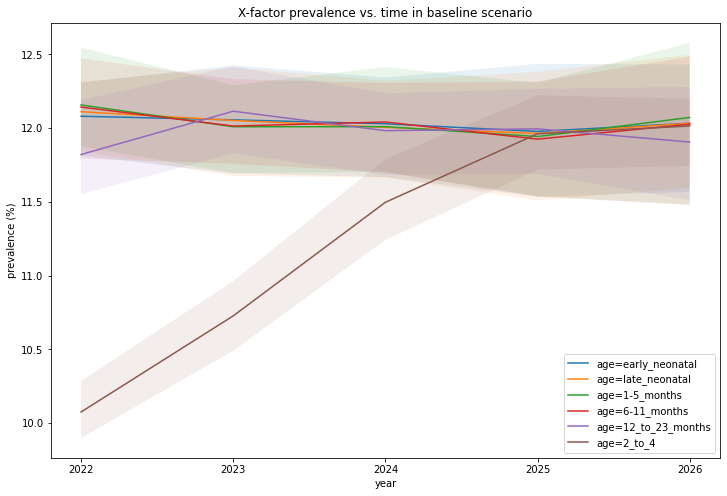

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
csp.plot_over_time_by_column(
    x_factor_prevalence.query("scenario=='baseline' and x_factor=='cat1'"),
    'age',
    'prevalence (%)',
    "X-factor prevalence vs. time in baseline scenario",
    True
)
figs['x_factor_prevalence_with_uncertainty_by_age_group_in_baseline'] = fig

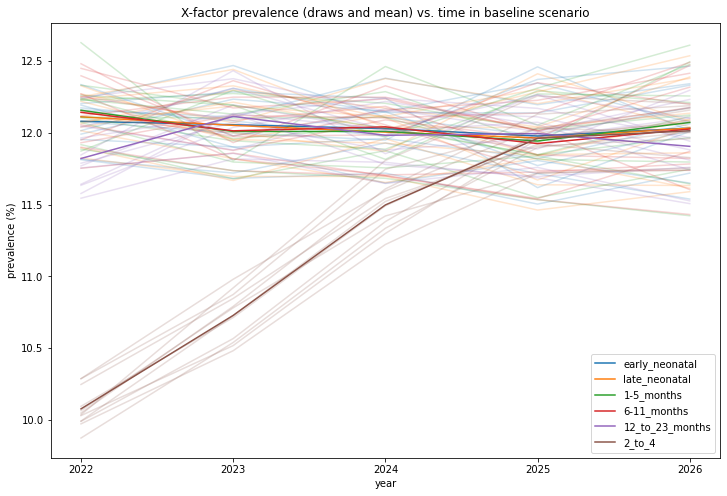

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
csp.plot_draws_over_time_by_age(
    x_factor_prevalence.query("scenario=='baseline' and x_factor=='cat1'"),
    'prevalence (%)',
    "X-factor prevalence (draws and mean) vs. time in baseline scenario",
)
figs['x_factor_prevalence_draws_by_age_group_in_baseline'] = fig

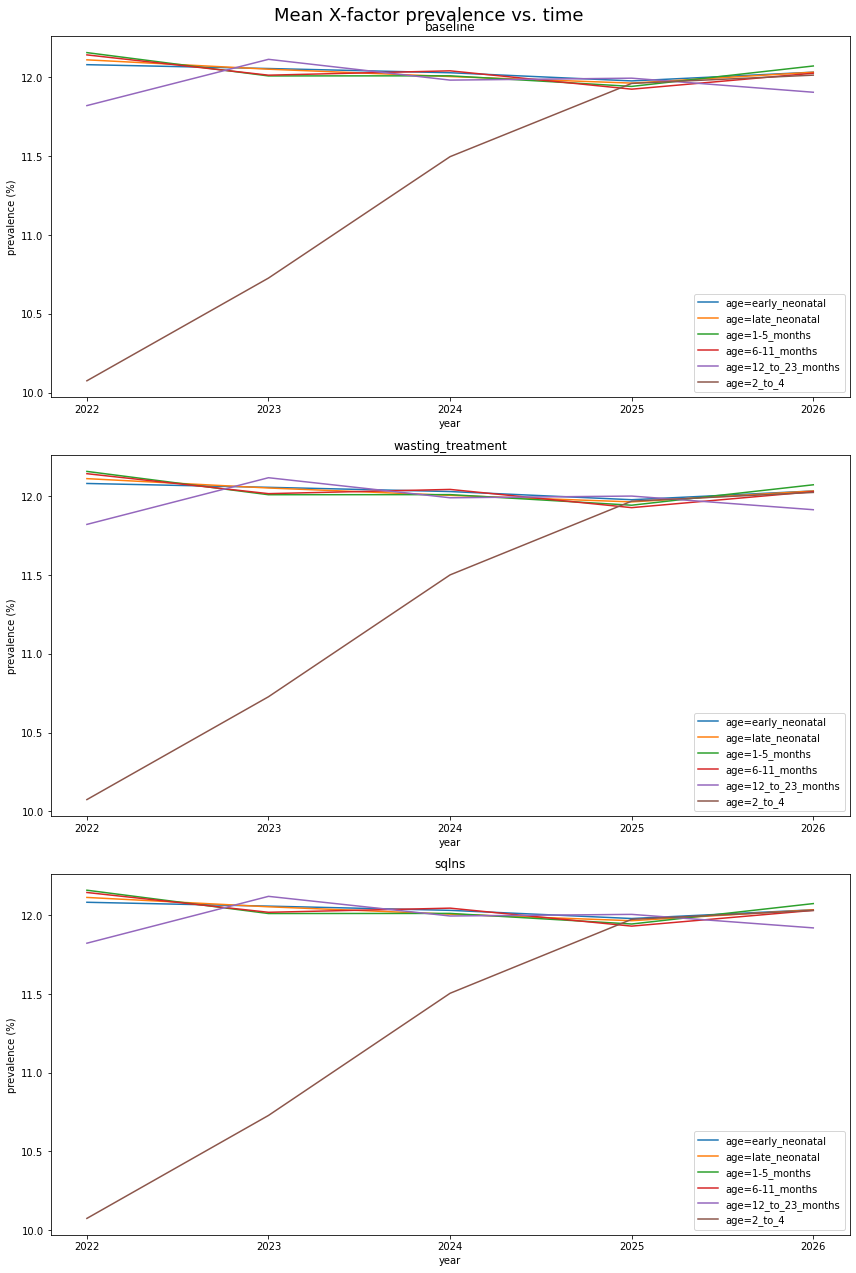

In [12]:
def plot_over_time_by_column_for_scenarios(df, colname, ylabel, suptitle):
    fig, axs = plt.subplots(len(csr.ordered_scenarios),1, figsize=(12,18))
    for s_num, scenario in enumerate(csr.ordered_scenarios):
        csp.plot_over_time_by_column(
            df.query("scenario==@scenario"),
            colname,
            ylabel,
            f"{scenario}",
            False,
            ax=axs[s_num],
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# x_factor_effect=1.5
fig = plot_over_time_by_column_for_scenarios(
    x_factor_prevalence.query(f"x_factor=='cat1'"),
    'age',
    ylabel='prevalence (%)',
    suptitle=f"Mean X-factor prevalence vs. time",
)
figs['x_factor_prevalence_by_age_group_in_all_scenarios'] = fig

# Compute X-factor prevalence stratified by year, age, wasting state

In [20]:
x_factor_prevalence_by_wasting_state = csr.get_prevalence(
    data, 'x_factor', strata=['year', 'age', 'wasting_state'], multiplier=100
)
x_factor_prevalence_by_wasting_state

,year,age,wasting_state,input_draw,scenario,x_factor,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,mild_child_wasting,29,baseline,cat1,25.768590,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,mild_child_wasting,29,baseline,cat2,74.231410,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,mild_child_wasting,29,sqlns,cat1,25.768590,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,mild_child_wasting,29,sqlns,cat2,74.231410,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...,...
8636,2026,late_neonatal,susceptible_to_child_wasting,946,sqlns,cat1,1.114451,state_person_time,state_person_time,100,prevalence
8637,2026,late_neonatal,susceptible_to_child_wasting,946,sqlns,cat2,98.885549,state_person_time,state_person_time,100,prevalence
8638,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,cat1,1.114451,state_person_time,state_person_time,100,prevalence
8639,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,cat2,98.885549,state_person_time,state_person_time,100,prevalence


# Plot X-factor prevalence in each wasting state for each age group

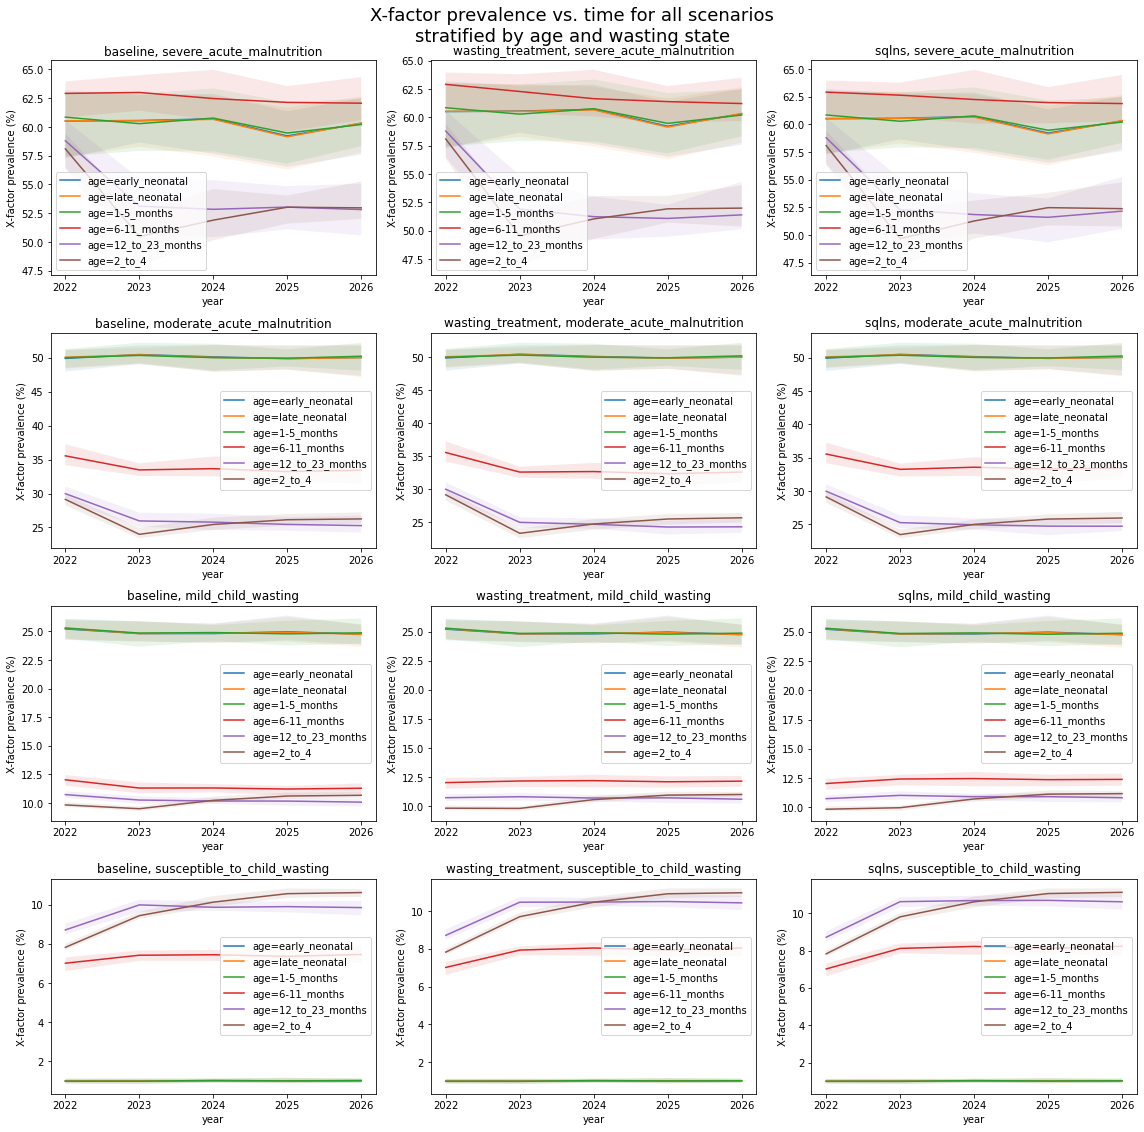

In [51]:
title = "X-factor prevalence vs. time for all scenarios\nstratified by age and wasting state"
fig = csp.plot_over_time_by_column_for_each_wasting_state_and_scenario(
    x_factor_prevalence_by_wasting_state.query("x_factor=='cat1'"),
    colname='age',
    ylabel='X-factor prevalence (%)',
    suptitle=title
)

In [16]:
df = csr.to_ordered_categoricals(x_factor_prevalence_by_wasting_state)
df.wasting_state

0                 mild_child_wasting
1                 mild_child_wasting
2                 mild_child_wasting
3                 mild_child_wasting
                    ...             
8636    susceptible_to_child_wasting
8637    susceptible_to_child_wasting
8638    susceptible_to_child_wasting
8639    susceptible_to_child_wasting
Name: wasting_state, Length: 8640, dtype: category
Categories (6, object): ['severe_acute_malnutrition' < 'moderate_acute_malnutrition' < 'mild_child_wasting' < 'susceptible_to_child_wasting' < 'acute_malnutrition' < 'no_acute_malnutrition']

In [19]:
df.wasting_state.unique()

['mild_child_wasting', 'moderate_acute_malnutrition', 'severe_acute_malnutrition', 'susceptible_to_child_wasting']
Categories (6, object): ['severe_acute_malnutrition' < 'moderate_acute_malnutrition' < 'mild_child_wasting' < 'susceptible_to_child_wasting' < 'acute_malnutrition' < 'no_acute_malnutrition']

In [25]:
df.wasting_state.unique().sort_values()

['severe_acute_malnutrition', 'moderate_acute_malnutrition', 'mild_child_wasting', 'susceptible_to_child_wasting']
Categories (6, object): ['severe_acute_malnutrition' < 'moderate_acute_malnutrition' < 'mild_child_wasting' < 'susceptible_to_child_wasting' < 'acute_malnutrition' < 'no_acute_malnutrition']

# Load model spec yaml file...

...and experiment with displaying the contents.

Turns out you can just do `print(yaml.dump(model_spec)))` after loading the file into a dictionary called `model_spec`. (Duh, of course it's easy.)

In [29]:
count_data_path = csr.get_count_data_path('4.5.3')
count_data_path

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/count_data/'

In [33]:
output_path = count_data_path[:-len('count_data/')]
output_path

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/'

In [34]:
!ls /ihme/costeffectiveness/results/vivarium_ciff_sam/v4.5.3_x_factor_targeted_exposure/ciff_sam/2021_11_02_20_09_56/

branches.yaml  logs			 __pycache__
count_data     model_specification.yaml  requirements.txt
keyspace.yaml  output.hdf		 settings.py


In [39]:
model_spec_path = f"{output_path}/model_specification.yaml"
with open(model_spec_path, 'r') as model_spec_file:
    model_spec = yaml.load(model_spec_file, Loader=yaml.SafeLoader)
print(model_spec)

{'components': {'vivarium_ciff_sam': {'components': ['ChildWasting()', 'LowBirthWeight()', 'ShortGestation()', "DiseaseEffect('risk_factor.child_wasting', 'risk_factor.x_factor.exposure_parameters')", 'SQLNSTreatment()', 'SQLNSIntervention()', 'WastingTreatmentIntervention()', "DisabilityObserver('wasting')", "MortalityObserver('wasting')", "DiseaseObserver('diarrheal_diseases', 'wasting')", "DiseaseObserver('measles', 'wasting')", "DiseaseObserver('lower_respiratory_infections', 'wasting')", "DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')", "CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')"]}, 'vivarium_public_health': {'disease': ["SIS('diarrheal_diseases')", "SIS_fixed_duration('measles', '10.0')", "SIS('lower_respiratory_infections')"], 'population': ['BasePopulation()', 'Mortality()', 'FertilityCrudeBirthRate()'], 'risks': ["RiskEffect('risk_factor.child_wasting', 'cause.diarrheal_diseases.incidence_rate')", "RiskEffect('risk_facto

In [41]:
pd.json_normalize(model_spec).T

,0
components.vivarium_ciff_sam.components,"[ChildWasting(), LowBirthWeight(), ShortGestat..."
components.vivarium_public_health.disease,"[SIS('diarrheal_diseases'), SIS_fixed_duration..."
components.vivarium_public_health.population,"[BasePopulation(), Mortality(), FertilityCrude..."
components.vivarium_public_health.risks,"[RiskEffect('risk_factor.child_wasting', 'caus..."
...,...
plugins.required.data.builder_interface,vivarium.framework.artifact.ArtifactInterface
plugins.required.data.controller,vivarium.framework.artifact.ArtifactManager
plugins.required.lifecycle.builder_interface,vivarium.framework.lifecycle.LifeCycleInterface
plugins.required.lifecycle.controller,vivarium.framework.lifecycle.LifeCycleManager


In [42]:
model_spec.keys()

dict_keys(['components', 'configuration', 'plugins'])

In [43]:
model_spec['configuration'].keys()

dict_keys(['child_wasting', 'effect_of_child_wasting_on_x_factor', 'effect_of_x_factor_on_mild_child_wasting', 'effect_of_x_factor_on_mild_child_wasting_to_moderate_acute_malnutrition', 'effect_of_x_factor_on_moderate_acute_malnutrition_to_severe_acute_malnutrition', 'input_data', 'interpolation', 'intervention', 'metrics', 'population', 'randomness', 'time'])

In [44]:
model_spec['configuration']['effect_of_child_wasting_on_x_factor']

{'exposure_parameters': {'mild_child_wasting': 0.25,
  'moderate_acute_malnutrition': 0.5,
  'severe_acute_malnutrition': 0.6,
  'susceptible_to_child_wasting': 0.01}}

In [45]:
pd.json_normalize(model_spec).columns

Index(['components.vivarium_ciff_sam.components',
       'components.vivarium_public_health.disease',
       'components.vivarium_public_health.population',
       'components.vivarium_public_health.risks',
       'configuration.child_wasting.mild_child_wasting_untreated_recovery_time',
       'configuration.effect_of_child_wasting_on_x_factor.exposure_parameters.mild_child_wasting',
       'configuration.effect_of_child_wasting_on_x_factor.exposure_parameters.moderate_acute_malnutrition',
       'configuration.effect_of_child_wasting_on_x_factor.exposure_parameters.severe_acute_malnutrition',
       'configuration.effect_of_child_wasting_on_x_factor.exposure_parameters.susceptible_to_child_wasting',
       'configuration.effect_of_x_factor_on_mild_child_wasting.incidence_rate.relative_risk',
       'configuration.effect_of_x_factor_on_mild_child_wasting_to_moderate_acute_malnutrition.transition_rate.relative_risk',
       'configuration.effect_of_x_factor_on_moderate_acute_malnutritio

In [49]:
pd.json_normalize(model_spec, max_level=2).columns

Index(['components.vivarium_ciff_sam.components',
       'components.vivarium_public_health.disease',
       'components.vivarium_public_health.population',
       'components.vivarium_public_health.risks',
       'configuration.child_wasting.mild_child_wasting_untreated_recovery_time',
       'configuration.effect_of_child_wasting_on_x_factor.exposure_parameters',
       'configuration.effect_of_x_factor_on_mild_child_wasting.incidence_rate',
       'configuration.effect_of_x_factor_on_mild_child_wasting_to_moderate_acute_malnutrition.transition_rate',
       'configuration.effect_of_x_factor_on_moderate_acute_malnutrition_to_severe_acute_malnutrition.transition_rate',
       'configuration.input_data.artifact_path',
       'configuration.input_data.input_draw_number',
       'configuration.input_data.location',
       'configuration.interpolation.extrapolate',
       'configuration.interpolation.order',
       'configuration.intervention.scenario',
       'configuration.metrics.child

In [50]:
pd.json_normalize(model_spec, max_level=2).T

,0
components.vivarium_ciff_sam.components,"[ChildWasting(), LowBirthWeight(), ShortGestat..."
components.vivarium_public_health.disease,"[SIS('diarrheal_diseases'), SIS_fixed_duration..."
components.vivarium_public_health.population,"[BasePopulation(), Mortality(), FertilityCrude..."
components.vivarium_public_health.risks,"[RiskEffect('risk_factor.child_wasting', 'caus..."
...,...
plugins.required.component_configuration_parser,"{'builder_interface': None, 'controller': 'viv..."
plugins.required.component_manager,{'builder_interface': 'vivarium.framework.comp...
plugins.required.data,{'builder_interface': 'vivarium.framework.arti...
plugins.required.lifecycle,{'builder_interface': 'vivarium.framework.life...


In [58]:
"yak".replace('a', 'y')

'yyk'

In [59]:
'goat'.split('.')

['goat']

In [76]:
def tabify(s):
    subkeys = s.split('.')
    tabs = ':\n'
    result = subkeys[0]
    for key in subkeys[1:]:
        tabs+='\t'
        result += tabs+key
    return result

tabified = tabify('configuration.metrics.child_wasting_observer.by_age')
print(repr(tabified))
print(tabified)
print(tabified.expandtabs(4))

'configuration:\n\tmetrics:\n\t\tchild_wasting_observer:\n\t\t\tby_age'
configuration:
	metrics:
		child_wasting_observer:
			by_age
configuration:
    metrics:
        child_wasting_observer:
            by_age


In [73]:
def print_model_spec(model_spec):
    df = pd.json_normalize(model_spec)
#     keys = df.columns.str.replace('.', ':\n', regex=False)
    keys = df.columns.map(tabify)
    lines = keys + ": " + df.loc[0].astype(str)
    print("\n".join(lines)) 
print_model_spec(model_spec)

components:
	vivarium_ciff_sam:
		components: ['ChildWasting()', 'LowBirthWeight()', 'ShortGestation()', "DiseaseEffect('risk_factor.child_wasting', 'risk_factor.x_factor.exposure_parameters')", 'SQLNSTreatment()', 'SQLNSIntervention()', 'WastingTreatmentIntervention()', "DisabilityObserver('wasting')", "MortalityObserver('wasting')", "DiseaseObserver('diarrheal_diseases', 'wasting')", "DiseaseObserver('measles', 'wasting')", "DiseaseObserver('lower_respiratory_infections', 'wasting')", "DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')", "CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')"]
components:
	vivarium_public_health:
		disease: ["SIS('diarrheal_diseases')", "SIS_fixed_duration('measles', '10.0')", "SIS('lower_respiratory_infections')"]
components:
	vivarium_public_health:
		population: ['BasePopulation()', 'Mortality()', 'FertilityCrudeBirthRate()']
components:
	vivarium_public_health:
		risks: ["RiskEffect('risk_factor.child_wast

In [57]:
with open(model_spec_path, 'r') as model_spec_file:
    model_spec_file_lines = model_spec_file.readlines()
for line in model_spec_file_lines:
    print(line, end='')

components:
  vivarium_ciff_sam:
    components:
    - ChildWasting()
    - LowBirthWeight()
    - ShortGestation()
    - DiseaseEffect('risk_factor.child_wasting', 'risk_factor.x_factor.exposure_parameters')
    - SQLNSTreatment()
    - SQLNSIntervention()
    - WastingTreatmentIntervention()
    - DisabilityObserver('wasting')
    - MortalityObserver('wasting')
    - DiseaseObserver('diarrheal_diseases', 'wasting')
    - DiseaseObserver('measles', 'wasting')
    - DiseaseObserver('lower_respiratory_infections', 'wasting')
    - DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')
    - CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')
  vivarium_public_health:
    disease:
    - SIS('diarrheal_diseases')
    - SIS_fixed_duration('measles', '10.0')
    - SIS('lower_respiratory_infections')
    population:
    - BasePopulation()
    - Mortality()
    - FertilityCrudeBirthRate()
    risks:
    - RiskEffect('risk_factor.child_wasting', 'cause.di

In [88]:
print(yaml.dump(model_spec))

components:
  vivarium_ciff_sam:
    components:
    - ChildWasting()
    - LowBirthWeight()
    - ShortGestation()
    - DiseaseEffect('risk_factor.child_wasting', 'risk_factor.x_factor.exposure_parameters')
    - SQLNSTreatment()
    - SQLNSIntervention()
    - WastingTreatmentIntervention()
    - DisabilityObserver('wasting')
    - MortalityObserver('wasting')
    - DiseaseObserver('diarrheal_diseases', 'wasting')
    - DiseaseObserver('measles', 'wasting')
    - DiseaseObserver('lower_respiratory_infections', 'wasting')
    - DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')
    - CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')
  vivarium_public_health:
    disease:
    - SIS('diarrheal_diseases')
    - SIS_fixed_duration('measles', '10.0')
    - SIS('lower_respiratory_infections')
    population:
    - BasePopulation()
    - Mortality()
    - FertilityCrudeBirthRate()
    risks:
    - RiskEffect('risk_factor.child_wasting', 'cause.di

In [83]:
model_spec

{'components': {'vivarium_ciff_sam': {'components': ['ChildWasting()',
    'LowBirthWeight()',
    'ShortGestation()',
    "DiseaseEffect('risk_factor.child_wasting', 'risk_factor.x_factor.exposure_parameters')",
    'SQLNSTreatment()',
    'SQLNSIntervention()',
    'WastingTreatmentIntervention()',
    "DisabilityObserver('wasting')",
    "MortalityObserver('wasting')",
    "DiseaseObserver('diarrheal_diseases', 'wasting')",
    "DiseaseObserver('measles', 'wasting')",
    "DiseaseObserver('lower_respiratory_infections', 'wasting')",
    "DiseaseObserver('child_wasting', 'False', 'sq_lns', 'wasting_treatment', 'x_factor')",
    "CategoricalRiskObserver('child_stunting', 'False', 'sq_lns')"]},
  'vivarium_public_health': {'disease': ["SIS('diarrheal_diseases')",
    "SIS_fixed_duration('measles', '10.0')",
    "SIS('lower_respiratory_infections')"],
   'population': ['BasePopulation()',
    'Mortality()',
    'FertilityCrudeBirthRate()'],
   'risks': ["RiskEffect('risk_factor.child_wa

# Define directories for saving figures

In [13]:
# project_results_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam'
model_name = 'v4.5.2_x_factor'
model_timestamp = '2021_09_29_12_12_47'
username = 'ndbs'

In [14]:
# model_count_data_dir = f'{project_results_dir}/{model_name}/ciff_sam/{model_timestamp}/count_data/'

project_vv_directory_name = 'ciff_malnutrition/verification_and_validation'

output_dir = f'/ihme/homes/{username}/vivarium_results/{project_vv_directory_name}/{model_name}'
share_output_dir = f'/share/scratch/users/ndbs/vivarium_results/{project_vv_directory_name}/{model_name}'
j_output_dir = f'/home/j/Project/simulation_science/{project_vv_directory_name}/{model_name}'

# Create the output directories if they don't exist
# Note from Path.mkdir() documentation:
#   "If mode is given, it is combined with the process’ umask value to determine the file mode and access flags."
#
# I don't know what this notebook process' umask value will be, so I don't know if this will actually result
# in the correct (most permissive) permissions for the directories...
for directory in [output_dir, share_output_dir, j_output_dir]:
    Path(directory).mkdir(mode=0o777, parents=True, exist_ok=True)

# Save figures to my home directory and J drive

In [15]:
list(figs.keys())

['x_factor_prevalence_by_age_group_in_baseline_x_factor_1.1',
 'x_factor_prevalence_by_age_group_in_baseline_x_factor_1.5',
 'x_factor_prevalence_with_uncertainty_by_age_group_in_baseline_x_factor_1.1',
 'x_factor_prevalence_draws_by_age_group_in_baseline_x_factor_1.1',
 'x_factor_prevalence_by_age_group_in_all_scenarios_x_factor_1.5']

In [16]:
for figure_name, fig in figs.items():
    for directory in [output_dir, j_output_dir]: 
        fig.savefig(f"{directory}/{figure_name}.pdf")

In [17]:
!ls /home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v4.5.2_x_factor/

wasting_prevalence_by_age_group_averaged_over_x_factor.pdf
wasting_prevalence_by_age_group_x_factor_1.1.pdf
wasting_prevalence_by_age_group_x_factor_1.5.pdf
wasting_prevalence_by_x_factor_age_12-23_months.pdf
wasting_prevalence_by_x_factor_age_2_to_4.pdf
wasting_prevalence_by_x_factor_age_6-11_months.pdf
wasting_prevalence_by_x_factor_age_over_6mo_averaged.pdf
wasting_prevalence_by_x_factor_age_over_6mo.pdf
wasting_prevalence_by_x_factor_age_over_6mo_with_uncertainty.pdf
wasting_prevalence_by_x_factor_age_under_6mo_averaged.pdf
wasting_prevalence_by_x_factor_age_under_6mo.pdf
wasting_prevalence_by_x_factor_all_ages_with_uncertainty.pdf
wasting_prevalence_by_x_factor_among_no_x_factor.pdf
wasting_prevalence_by_x_factor_among_x_factor.pdf
x_factor_prevalence_by_age_group_in_all_scenarios_x_factor_1.5.pdf
x_factor_prevalence_by_age_group_in_baseline_x_factor_1.1.pdf
x_factor_prevalence_by_age_group_in_baseline_x_factor_1.5.pdf
x_factor_prevalence_draws_by_age_group_in_baseline_x_factor_1.

# Write a function to check that total person-time is equal for all cause state observers

In [18]:
data.cause_state_person_time

,sex,year,cause_state,measure,input_draw,scenario,x_factor_effect,value,wasting_state,age,cause
0,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,2.802190,susceptible_to_child_wasting,early_neonatal,diarrheal_diseases
1,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,0.706366,mild_child_wasting,early_neonatal,diarrheal_diseases
2,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,0.394251,moderate_acute_malnutrition,early_neonatal,diarrheal_diseases
3,female,2022,diarrheal_diseases,state_person_time,29,baseline,1.1,0.112252,severe_acute_malnutrition,early_neonatal,diarrheal_diseases
...,...,...,...,...,...,...,...,...,...,...,...
259196,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,21982.043806,susceptible_to_child_wasting,2_to_4,measles
259197,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,7332.421629,mild_child_wasting,2_to_4,measles
259198,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,2161.859001,moderate_acute_malnutrition,2_to_4,measles
259199,male,2026,susceptible_to_measles,state_person_time,946,wasting_treatment,1.5,415.915127,severe_acute_malnutrition,2_to_4,measles


In [19]:
cause_pt = vp.marginalize(data.cause_state_person_time, 'cause_state')
cause_pt

,age,cause,input_draw,measure,scenario,sex,wasting_state,x_factor_effect,year,value
0,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2022,856.239562
1,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2023,874.479124
2,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2024,903.897331
3,1-5_months,diarrheal_diseases,29,state_person_time,baseline,female,mild_child_wasting,1.1,2025,913.613963
...,...,...,...,...,...,...,...,...,...,...
129596,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2023,417.906913
129597,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2024,407.952088
129598,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2025,412.099932
129599,late_neonatal,measles,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2026,403.015743


In [20]:
first_cause, *remaining_causes = cause_pt.cause.unique()
pt = cause_pt.query("cause==@first_cause").drop(columns='cause')
for cause in remaining_causes:
    print(pt.equals(cause_pt.query("cause==@cause").drop(columns='cause')))
    vp.assert_values_equal(pt, cause_pt.query("cause==@cause").drop(columns='cause'))
pt

False
False


,age,input_draw,measure,scenario,sex,wasting_state,x_factor_effect,year,value
0,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2022,856.239562
1,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2023,874.479124
2,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2024,903.897331
3,1-5_months,29,state_person_time,baseline,female,mild_child_wasting,1.1,2025,913.613963
...,...,...,...,...,...,...,...,...,...
115196,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2023,417.906913
115197,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2024,407.952088
115198,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2025,412.099932
115199,late_neonatal,946,state_person_time,wasting_treatment,male,susceptible_to_child_wasting,1.5,2026,403.015743


In [21]:
def assert_cause_person_time_equal(data):
    cause_person_time = csr.get_total_person_time(data, 'cause')
    first_cause, *remaining_causes = cause_person_time.cause.unique()
    person_time = cause_person_time.query("cause==@first_cause").drop(columns='cause')
    # Check that total person-time is the same for all causes
    for cause in remaining_causes:
        vp.assert_values_equal(person_time, cause_person_time.query("cause==@cause").drop(columns='cause'))

In [22]:
assert_cause_person_time_equal(data)